In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tongpython_cat_and_dog_path = kagglehub.dataset_download('tongpython/cat-and-dog')

print('Data source import complete.')


Using Colab cache for faster access to the 'cat-and-dog' dataset.
Data source import complete.



# 1) Imports


In [2]:
!pip install --upgrade protobuf==3.20.*


In [3]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


# 2) load File Paths (Cats / Dogs)

In [4]:

train_path = "/kaggle/input/cat-and-dog/training_set/training_set"
test_path  = "/kaggle/input/cat-and-dog/test_set/test_set"

cats_train_dir = os.path.join(train_path, "cats")
dogs_train_dir = os.path.join(train_path, "dogs")

cats_test_dir = os.path.join(test_path, "cats")
dogs_test_dir = os.path.join(test_path, "dogs")

print("Number of training cat images:", len(os.listdir(cats_train_dir)))
print("Number of training dog images:", len(os.listdir(dogs_train_dir)))
print("Number of testing cat images:", len(os.listdir(cats_test_dir)))
print("Number of testing dog images:", len(os.listdir(dogs_test_dir)))

Number of training cat images: 4001
Number of training dog images: 4006
Number of testing cat images: 1012
Number of testing dog images: 1013



# 3) Display random sample images from Train


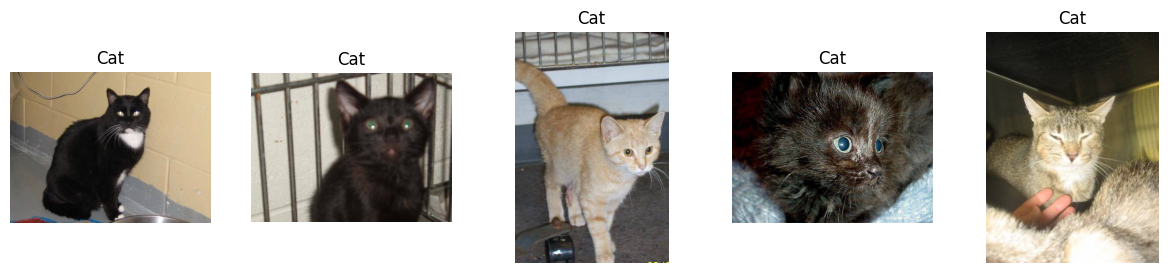

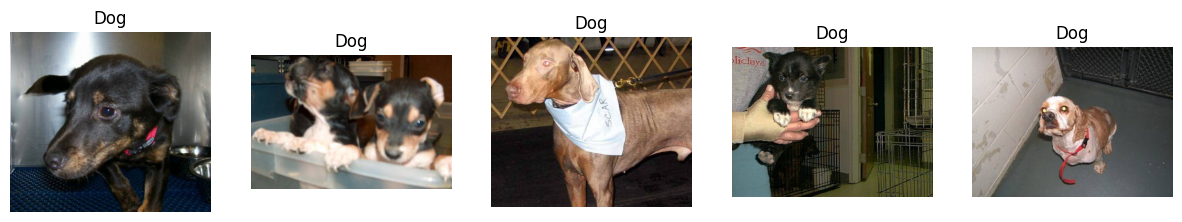

In [5]:

def show_samples(folder, label, n=5):
    plt.figure(figsize=(15,3))
    sample_files = random.sample(os.listdir(folder), n)
    for i, img_name in enumerate(sample_files):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_samples(cats_train_dir, "Cat")
show_samples(dogs_train_dir, "Dog")



# 4) Load images safely


In [6]:

IMG_SIZE = 128
X = []
y = []

def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg'))

# Cats
for f in os.listdir(cats_train_dir):
    if is_image_file(f):
        img = Image.open(os.path.join(cats_train_dir, f)).resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(img))
        y.append(0)

# Dogs
for f in os.listdir(dogs_train_dir):
    if is_image_file(f):
        img = Image.open(os.path.join(dogs_train_dir, f)).resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(img))
        y.append(1)

X = np.array(X)
y = np.array(y)
print("Dataset shape:", X.shape, y.shape)


Dataset shape: (8005, 128, 128, 3) (8005,)



# 5) Split into Train and Validation


In [8]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train / 255.0
X_val   = X_val / 255.0

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("x:", X_train[0][0])


Train shape: (6404, 128, 128, 3) (6404,)
Validation shape: (1601, 128, 128, 3) (1601,)
x: [[0.65490196 0.64705882 0.41568627]
 [0.65098039 0.64313725 0.41568627]
 [0.64705882 0.63529412 0.41568627]
 [0.63137255 0.61960784 0.40784314]
 [0.63529412 0.62352941 0.41960784]
 [0.63137255 0.61960784 0.41960784]
 [0.65098039 0.62352941 0.43137255]
 [0.65098039 0.61960784 0.43529412]
 [0.64313725 0.61176471 0.43137255]
 [0.64705882 0.61176471 0.44313725]
 [0.64705882 0.61176471 0.44705882]
 [0.64313725 0.60784314 0.44705882]
 [0.63137255 0.60784314 0.44313725]
 [0.62745098 0.60784314 0.44313725]
 [0.62745098 0.60784314 0.44313725]
 [0.62745098 0.60784314 0.44313725]
 [0.63529412 0.61568627 0.45098039]
 [0.63529412 0.61568627 0.44705882]
 [0.63137255 0.60784314 0.4627451 ]
 [0.63137255 0.60784314 0.4745098 ]
 [0.64313725 0.61960784 0.48235294]
 [0.63529412 0.61568627 0.47058824]
 [0.62745098 0.60784314 0.45490196]
 [0.63137255 0.61176471 0.45490196]
 [0.64705882 0.62745098 0.47058824]
 [0.635294


# 6) Display random images from Train & Validation


Random Train Images:


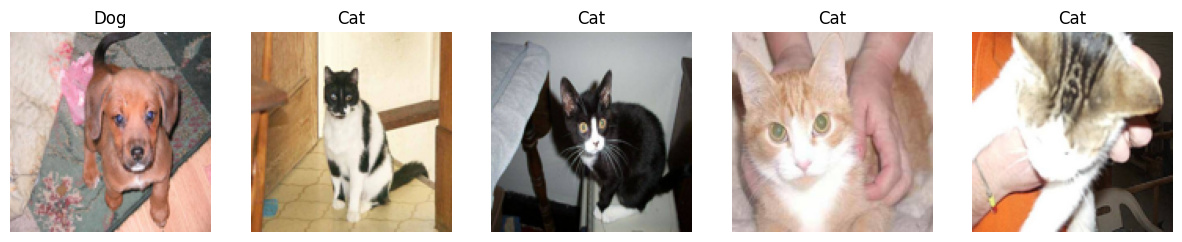

Random Validation Images:


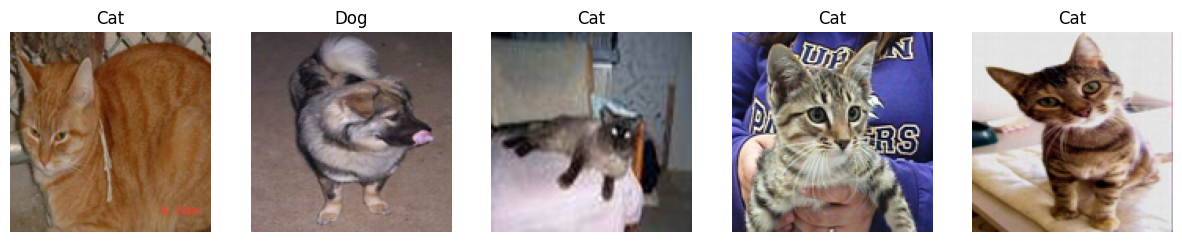

In [ ]:

def show_random_batch(X, y, n=5):
    plt.figure(figsize=(15,3))
    idxs = random.sample(range(len(X)), n)
    for i, idx in enumerate(idxs):
        plt.subplot(1,n,i+1)
        plt.imshow(X[idx])
        plt.title("Cat" if y[idx]==0 else "Dog")
        plt.axis('off')
    plt.show()

print("Random Train Images:")
show_random_batch(X_train, y_train)

print("Random Validation Images:")
show_random_batch(X_val, y_val)



# 7) Data Augmentation


In [ ]:

datagen = ImageDataGenerator()
train_generator = datagen.flow(X_train, y_train, batch_size=32)



# 8) Build CNN Model


In [ ]:

model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,298,178 (96.50 MB)

 Trainable params: 25,298,178 (96.50 MB)

 Non-trainable params: 0 (0.00 B)


# 9) Compile Model


In [ ]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



# 10) EarlyStopping


In [ ]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)



# 11) Train Model


In [ ]:

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 106s 508ms/step - accuracy: 0.4924 - loss: 10.6866 - val_accuracy: 0.5047 - val_loss: 0.6936
Epoch 2/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 94s 468ms/step - accuracy: 0.4832 - loss: 0.6935 - val_accuracy: 0.5009 - val_loss: 0.6936
Epoch 3/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 94s 469ms/step - accuracy: 0.4868 - loss: 0.6993 - val_accuracy: 0.5003 - val_loss: 0.6935
Epoch 4/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 152s 519ms/step - accuracy: 0.5034 - loss: 0.6931 - val_accuracy: 0.4984 - val_loss: 0.6935
Epoch 5/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 143s 524ms/step - accuracy: 0.4904 - loss: 0.6935 - val_accuracy: 0.4984 - val_loss: 0.6935
Epoch 6/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 147s 545ms/step - accuracy: 0.4871 - loss: 0.6934 - val_accuracy: 0.5003 - val_loss: 0.6935
Epoch 7/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 105s 523ms/step - accuracy: 0.4981 - loss: 0.6933 - val_accuracy: 0.5003 - val_loss: 0.6936
Epoch 8/60
201/201 ━━━━━━━━━━━━━━━━━━━━ 141s 522ms/step - accuracy: 0.4885 - 


# 12) Plot Accuracy & Loss


In [ ]:

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()



# 13) Prepare Test Dataset


In [ ]:

X_test, y_test = [], []
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg'))


for f in os.listdir(cats_test_dir):
    if is_image_file(f):
      img = Image.open(os.path.join(cats_test_dir, f)).resize((IMG_SIZE, IMG_SIZE))
      X_test.append(np.array(img))
      y_test.append(0)

for f in os.listdir(dogs_test_dir):
   if is_image_file(f):
    img = Image.open(os.path.join(dogs_test_dir, f)).resize((IMG_SIZE, IMG_SIZE))
    X_test.append(np.array(img))
    y_test.append(1)

X_test = np.array(X_test) / 255.0
y_test = np.array(y_test)

print("Test Dataset shape:", X_test.shape, y_test.shape)



# 14) Evaluate Model on Test Dataset


In [ ]:

loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


# 15) Try model on test images

In [ ]:
def predict_multiple_images(n=5):
    indices = random.sample(range(len(X_test)), n)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = "Cat" if y_test[idx] == 0 else "Dog"

        pred = model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3))
        pred_label = "Cat" if np.argmax(pred) == 0 else "Dog"

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"T:{true_label}\nP:{pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
predict_multiple_images(5)
